In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from IPython.display import clear_output

In [5]:
from actler.model import ALModel
from actler.data import generate_rosen_data, make_dataloaders, DataLoader, SampleDataset, generate_func_data
from actler.sampler import random_sampling, mcdue_sampling
from actler.loss import RMSELoss, MSELoss
from actler.train_al import train_model, test_model, active_train_model, mae
from actler.plot import plot_history, plot_region

In [6]:
func = lambda X: (X**2).sum(axis=1) * 10

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_boston

In [8]:
cal_housing = pd.read_csv('CaliforniaHousing/cal_housing.data', header=None).values
columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]
cal_housing = cal_housing[:, columns_index]
target, data = cal_housing[:, 0], cal_housing[:, 1:]

# avg rooms = total rooms / households
data[:, 2] /= data[:, 5]

# avg bed rooms = total bed rooms / households
data[:, 3] /= data[:, 5]

# avg occupancy = population / households
data[:, 5] = data[:, 4] / data[:, 5]

# target in units of 100,000
target = target / 100000.0

In [9]:
X = data
y = target[:, None]

In [10]:
X, y = load_boston(True)
y = y[:, None]

In [8]:
X, y = generate_rosen_data(20000, 10)
# X_m, y_m, Xi, Xj, Y = generate_rosen_data(100, 2, True)

In [9]:
X.shape, y.shape

((20000, 10), (20000, 1))

In [10]:
dataloaders = make_dataloaders(X, y, [0.2, 0.7, 0.1, 0.1], 100)
# dataloaders['Mesh'] = DataLoader(SampleDataset(X_m, y_m), 256)

In [11]:
# plot_region(Xi, Xj, Y, np.array((dataloaders['Val'].dataset.X.tolist()))[:200])

In [19]:
# layers = [8, 256, 128, 64]
layers = [10, 256, 128, 128]
net = ALModel(layers, p=0.05)
criterion = RMSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.005)

params = {
    'model': net,
    'criterion': criterion,
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'n_epochs': 10000,
    'check_every': 10,
    'patience_max': 15
}

In [20]:
net

ALModel(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConstDropout(p=0.05)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): ConstDropout(p=0.05)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConstDropout(p=0.05)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
)

In [21]:
# y_pred = []
# for i in range(10):
#     clear_output(True)
#     y_pred.append(test_model(net, dataloaders['Mesh'], return_y=True, freeze_mask=True)[1])
    
# STD = np.std(y_pred, axis=0).reshape(Xi.shape)
# Y_PRED = np.mean(y_pred, axis=0).reshape(Xi.shape)

In [22]:
# plot_region(Xi, Xj, Y_PRED, np.array((dataloaders['Val'].dataset.X.tolist()))[:200])

In [23]:
# plot_region(Xi, Xj, STD, np.array((dataloaders['Val'].dataset.X.tolist()))[:200])

In [24]:
net, logs = train_model(**params)

--------------------
Training complete in 3 mins 37 seconds with 340 epochs


Testing model: 100%|██████████| 1900/1900 [00:00<00:00, 35378.31it/s]


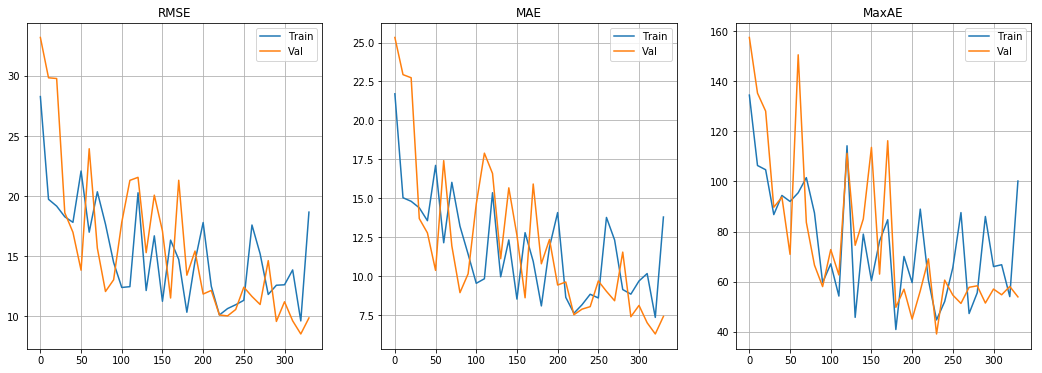

In [25]:
plot_history(logs)

In [26]:
def get_ae(net, dataloader):
    y_true, y_pred = test_model(net, dataloader, return_y=True)
    return abs(y_true - y_pred), y_true
    
def get_mcdue(mode, dataloader, T=10):
    y_preds = []
    for i in range(T):
        _, y_pred = test_model(net, dataloader, return_y=True, new_p=0.5)
        y_preds.append(y_pred)
#     return np.std(y_preds, axis=0)/np.mean(y_preds, axis=0)
    return np.std(y_preds, axis=0), np.mean(y_preds, axis=0)

In [27]:
dataloaders['TrainPool'].set_mode('pool')
ae, y1 = get_ae(net, dataloaders['TrainPool'])
mcdue, y2 = get_mcdue(net, dataloaders['TrainPool'])
dataloaders['TrainPool'].set_mode('train')

Testing model: 100%|██████████| 12800/12800 [00:01<00:00, 6644.06it/s]


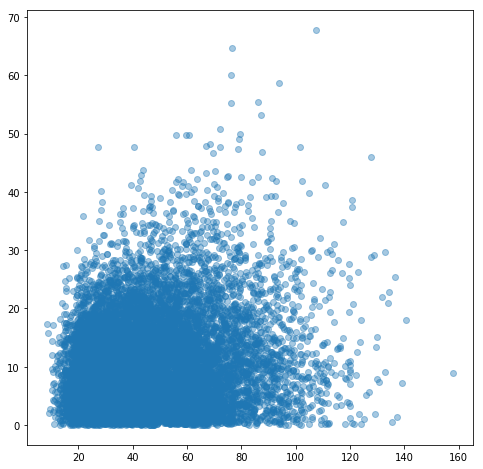

In [28]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter((mcdue).ravel(), (ae).ravel(), alpha=0.4)

In [29]:
ind = mcdue.ravel().argsort()[::-1][:300]

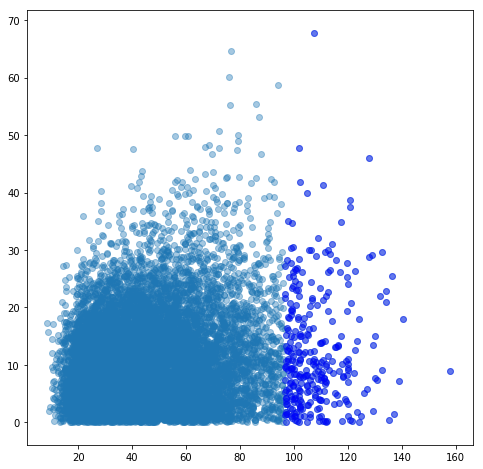

In [32]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter((mcdue).ravel(), (ae).ravel(), alpha=0.4)
ax.scatter((mcdue).ravel()[ind], (ae).ravel()[ind], alpha=0.4, c='b')

In [33]:
params = {
    'model': net,
    'criterion': criterion,
    'dataloaders': dataloaders,
    'acquisition_fun': random_sampling,
    'optimizer': optimizer,
    'n_al_epochs': 20,
    'n_train_epochs': 3000,
    'n_val': 5,
}


In [34]:
net, logs = active_train_model(**params)

AL Epoch #20 out of 20.
Last al train rmse: 5.93Last val rmse:   7.40
Train Epoch #869 out of 3000.
Learning rate: 0.0003
Last train rmse: 5.97
Last val rmse:   7.01


Training model:  77%|███████▋  | 12700/16400 [00:05<00:01, 2892.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
logs['check_every'] = 1

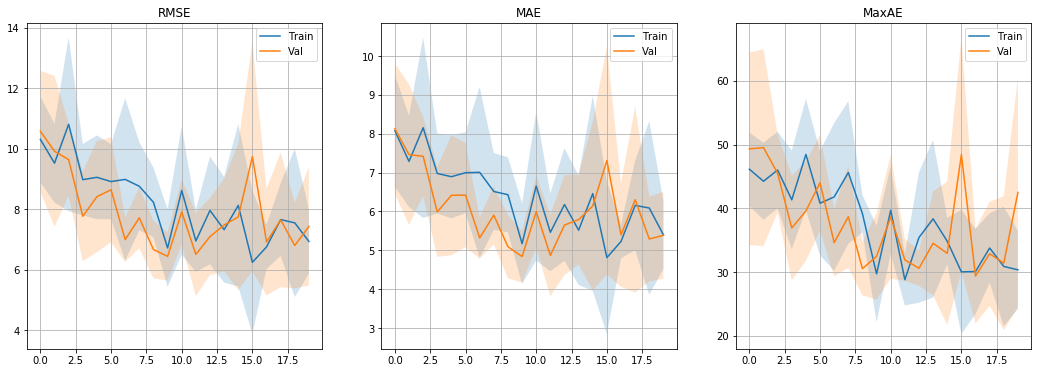

In [37]:
plot_history(logs)

In [38]:
from actler.model import ConstDropout

In [39]:
dropout = ConstDropout(10, p=0.1)

In [40]:
dropout(torch.ones(1, 10))

tensor([[1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111, 1.1111,
         1.1111]])

In [47]:
dropout.set_const_mask(0.5)
print(dropout(torch.ones(1, 10)))
dropout.unset_const_mask()

tensor([[2., 0., 0., 2., 0., 2., 2., 2., 0., 2.]])
